In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from backtest_functions import *

In [2]:
df = pd.read_parquet('/home/group5/WorkingFolder/data_production/v1_cleaned_monthly_price_review.parquet')
df_v2 = pd.read_parquet("/home/group5/WorkingFolder/data_production/v2_cleaned_monthly_price_review.parquet")

# rescale the data to [0,1]
df[["ratingOverall"
      ]] = (df[['ratingOverall'
      ]]-1 )/ 4

df[['ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
       
      ]] = df[[ 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',

      ]] / 5

df[['ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend'
      ]] = (df[['ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend'
      ]] + 1) / 2

# drop data before 2014
df2 = df[df.month >= "2014-01"]
df2.drop("ratingDiversityAndInclusion",axis = 1, inplace = True)

print(len(df2))

df2 = df2.sort_values(by = ['cusip','month'], ascending=True)

# create feature transformation
df_transformed = df2.groupby(['cusip'])[['ratingOverall', 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
      'ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend'
      ]].ewm(alpha = 0.5, ignore_na = True).mean().reset_index()

df_transformed = df_transformed.set_index('level_1')
df_transformed.index.name = None
df_transformed = pd.merge(df2.month, df_transformed, left_index=True,right_index=True)

df_transformed = pd.merge(
    df_transformed.dropna(), 
   df2[['month','cusip','review_count', 'return_forward_1m']],
    on = ['month','cusip']
)

404705


### Generate Signal

In [4]:

df_transformed['score'] = df_transformed[['ratingOverall', 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
       'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
]].mean(axis = 1)

df_transformed['score'] = np.where(df_transformed.review_count > 4, df_transformed.score, np.NaN) # filter for review count

#df_transformed['score'] = df_transformed.groupby(['month']).score.rank(pct = True)

#df_transformed['score'] = np.where((df_transformed['score'] > 0.8) | (df_transformed['score'] < 0.2), df_transformed.score, np.NaN)


### Signal to Position operations

In [5]:
return_xnd = df_transformed[['month','cusip','return_forward_1m']].pivot(index = 'month', columns = 'cusip', values = 'return_forward_1m')

Overall Annual Sharpe Ratio: 0.1451491926459756
--------------
Yearly Sharpe Ratio
month
2014    1.000000
2015    2.780144
2016    0.268634
2017    2.147064
2018    0.981198
2019    1.896322
2020   -0.886717
2021   -0.445348
2022   -0.443503
dtype: float64
--------------
Yearly Return (%)
month
2014     0.424765
2015     8.754587
2016     0.851960
2017     7.408949
2018     3.427275
2019     8.977949
2020   -16.962227
2021    -2.342049
2022    -1.016153
dtype: float64


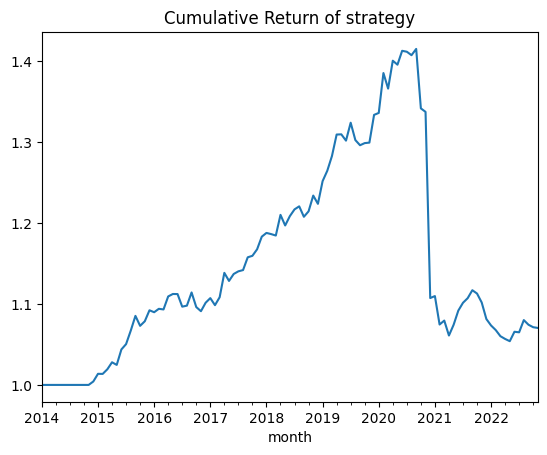

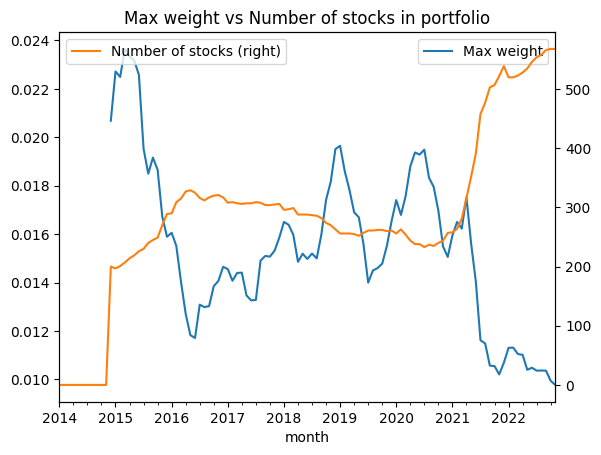

In [6]:
factor_xnd = df_transformed[['month','cusip','score']].pivot(index = 'month', columns = 'cusip', values = 'score')
#factor_xnd = portfolio_bins(factor_xnd, 0.2, 0.8)
factor_xnd = neutralise_by_group(factor_xnd, "gind")
factor_xnd = smooth_weights(factor_xnd, 12)
factor_xnd = neutralise_by_group(factor_xnd, "gind")

portfolio_return = run_backtest(return_xnd, factor_xnd)
plot_backtest(portfolio_return)
plot_weights(factor_xnd)